<a href="https://colab.research.google.com/github/gavincapriola/PyTorch-Deep-Learning-and-Artificial-Intelligence/blob/main/Recommender%20Systems/PyTorch_Recommender_20M_with_Preditions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.utils import shuffle

In [2]:
# data is from: https://grouplens.org/datasets/movielens/
!wget -nc https://files.grouplens.org/datasets/movielens/ml-20m.zip

--2022-10-23 18:25:08--  https://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  13.5MB/s    in 16s     

2022-10-23 18:25:25 (11.9 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [3]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [4]:
!ls

ml-20m	ml-20m.zip  sample_data


In [5]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [6]:
# We can't trust the userId and movieId to be numbered 0...N-1
# Let's just set our own ids

# current_user_id = 0
# custom_user_map = {} # old user id > new user id
# def map_user_id(row):
#     global current_user_id, custom_user_map
#     old_user_id = row['userId']
#     if old_user_id not in custom_user_map:
#         custom_user_map[old_user_id] = current_user_id
#         current_user_id += 1
#     return custom_user_map[old_user_id]

# df['new_user_id'] = df.apply(map_user_id, axis=1)

df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

In [7]:
# Now do the same for movieId

# current_movie_id = 0
# custom_movie_map = {} # old movie id > new movie id
# def map_movie_id(row):
#     global current_movie_id, custom_movie_map
#     old_movie_id = row['movieId']
#     if old_movie_id not in custom_movie_map:
#         custom_movie_map[old_movie_id] = current_movie_id
#         current_movie_id += 1
#     return custom_movie_map[old_movie_id]

# df['new_movie_id'] = df.apply(map_movie_id, axis=1)

df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [8]:
# Get user IDs, and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values - 2.5

In [9]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
D = 10

In [10]:
# Make the neural network
class Model(nn.Module):
    def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):
        super(Model, self).__init__()
        self.N = n_users
        self.M = n_items
        self.D = embed_dim
        
        self.u_emb = nn.Embedding(self.N, self.D)
        self.m_emb = nn.Embedding(self.M, self.D)
        self.fc1 = nn.Linear(2*self.D, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)

        # set the weights since N(0, 1) leads to poor results
        self.u_emb.weight.data = nn.Parameter(
            torch.Tensor(np.random.randn(self.N, self.D) * 0.01))
        self.m_emb.weight.data = nn.Parameter(
            torch.Tensor(np.random.randn(self.M, self.D) * 0.01))
        
    def forward(self, u, m):
        u = self.u_emb(u) # output is (num_samples, D)
        m = self.m_emb(m) # output is (num_samples, D)
        
        # merge
        out = torch.cat((u, m), 1) # output is (num_samples, 2D)
        
        # ANN
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda:0


In [12]:
model = Model(N, M, D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [13]:
# loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.08, momentum=0.9)

In [14]:
def batch_gd2(model, criterion, optimizer, train_data, test_data, epochs, bs=512):
    train_users, train_movies, train_ratings = train_data
    test_users, test_movies, test_ratings = test_data

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    # batches per epoch
    Ntrain = len(train_users)
    batches_per_epoch = int(np.ceil(Ntrain / bs))
    
    for it in range(epochs):
        t0 = datetime.datetime.now()
        train_loss = []

        # shuffle each batch
        train_users, train_movies, train_ratings = shuffle(
            train_users, train_movies, train_ratings
        )

        for j in range(batches_per_epoch):
            # get the batch
            users = train_users[j*bs:(j+1)*bs]
            movies = train_movies[j*bs:(j+1)*bs]
            targets = train_ratings[j*bs:(j+1)*bs]

            # conver to tensor
            users = torch.from_numpy(users).long()
            movies = torch.from_numpy(movies).long()
            targets = torch.from_numpy(targets)

            # reshape targets
            targets = targets.view(-1, 1).float()

            # move data to GPU
            users, movies, targets = users.to(device), movies.to(device), targets.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(users, movies)
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
        
        # Get train loss and test loss
        train_loss = np.mean(train_loss) # a little misleading
        
        test_loss = []
        for j in range(int(np.ceil(len(test_users) / bs))):
            # get the batch
            users = test_users[j*bs:(j+1)*bs]
            movies = test_movies[j*bs:(j+1)*bs]
            targets = test_ratings[j*bs:(j+1)*bs]

            # conver to tensor
            users = torch.from_numpy(users).long()
            movies = torch.from_numpy(movies).long()
            targets = torch.from_numpy(targets)

            # reshape targets
            targets = targets.view(-1, 1).float()

            # move data to GPU
            users, movies, targets = users.to(device), movies.to(device), targets.to(device)

            outputs = model(users, movies)
            loss = criterion(outputs, targets).item()
            test_loss.append(loss)
        test_loss = np.mean(test_loss)
        
        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        dt = datetime.datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}')
        
    return train_losses, test_losses

In [15]:
# shuffle the data in corresponding order
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [16]:
Ntrain = int(0.8 * len(ratings))
train_users = user_ids[:Ntrain]
train_movies = movie_ids[:Ntrain]
train_ratings = ratings[:Ntrain]

test_users = user_ids[Ntrain:]
test_movies = movie_ids[Ntrain:]
test_ratings = ratings[Ntrain:]

train_losses, test_losses = batch_gd2(
    model, 
    criterion, 
    optimizer, 
    (train_users, train_movies, train_ratings), 
    (test_users, test_movies, test_ratings), 
    10)

Epoch 1/10, Train Loss: 0.7374, Test Loss: 0.6914, Duration: 0:01:06.547766
Epoch 2/10, Train Loss: 0.6697, Test Loss: 0.6672, Duration: 0:01:00.788765
Epoch 3/10, Train Loss: 0.6377, Test Loss: 0.6449, Duration: 0:00:47.032619
Epoch 4/10, Train Loss: 0.6136, Test Loss: 0.6382, Duration: 0:00:52.671995
Epoch 5/10, Train Loss: 0.5962, Test Loss: 0.6316, Duration: 0:00:57.753333
Epoch 6/10, Train Loss: 0.5833, Test Loss: 0.6336, Duration: 0:00:48.079033
Epoch 7/10, Train Loss: 0.5738, Test Loss: 0.6287, Duration: 0:00:52.878735
Epoch 8/10, Train Loss: 0.5668, Test Loss: 0.6351, Duration: 0:01:04.672932
Epoch 9/10, Train Loss: 0.5612, Test Loss: 0.6276, Duration: 0:00:55.064745
Epoch 10/10, Train Loss: 0.5565, Test Loss: 0.6268, Duration: 0:00:48.740926


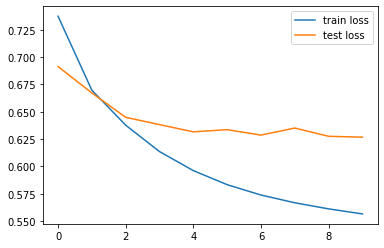

In [17]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [18]:
watched_movie_ids = df[df.new_user_id == 1].new_movie_id.values
watched_movie_ids

array([   2,   61,   69,  108,  239,  257,  263,  465,  476,  537,  583,
        874,  891,  907, 1098, 1171, 1184, 1188, 1221, 1231, 1242, 1298,
       1326, 1494, 1528, 1616, 1684, 1881, 1885, 1886, 1887, 1888, 1889,
       1890, 1902, 2206, 2369, 2370, 2705, 2772, 2862, 2865, 3063, 3072,
       3086, 3361, 3423, 3443, 3464, 3474, 3612, 3662, 3824, 3825, 3830,
       3833, 3834, 3835, 3837, 3843, 3865], dtype=int16)

In [19]:
potential_movie_ids = df[~df.new_movie_id.isin(watched_movie_ids)].new_movie_id.unique()

In [20]:
potential_movie_ids.shape

(26683,)

In [21]:
len(set(potential_movie_ids))

26683

In [22]:
user_id_to_recommend = np.ones_like(potential_movie_ids)

In [23]:
t_user_ids = torch.from_numpy(user_id_to_recommend).long().to(device)
t_movie_ids = torch.from_numpy(potential_movie_ids).long().to(device)

with torch.no_grad():
    predictions = model(t_user_ids, t_movie_ids)

In [24]:
predictions_np = predictions.cpu().numpy().flatten()

sort_idx = np.argsort(-predictions_np)

In [25]:
predictions_np

array([1.2587447, 0.7220087, 1.6171066, ..., 1.4478877, 1.4019637,
       1.4643028], dtype=float32)

In [26]:
sort_idx

array([  848,   744,    73, ...,  8583, 13520,  8795])

In [28]:
top_10_movie_ids = potential_movie_ids[sort_idx[:10]]
top_10_scores = predictions_np[sort_idx[:10]]

for movie, score in zip(top_10_movie_ids, top_10_scores):
    print("movie:", movie, "score:", score)

movie: 10109 score: 2.4926383
movie: 5281 score: 2.4732664
movie: 2543 score: 2.368692
movie: 843 score: 2.3581784
movie: 1212 score: 2.356043
movie: 1944 score: 2.355667
movie: 7356 score: 2.3546088
movie: 1238 score: 2.3536267
movie: 12206 score: 2.3326912
movie: 1017 score: 2.332078
